In [1]:
from pathlib import Path
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re

In [2]:
data_dir = Path("/Volumes/GH-ent-data-platform-rwe/share/Data/Mendel/nlp-poc-073123/data/mendel_output")
manifest_dir = Path("/Volumes/GH-ent-data-platform-rwe/share/Data/Mendel/nlp-poc-073123/manifest/mendel_output")

In [3]:
our_results_dir = Path("/Users/cpan/Desktop/Entities_compare")

In [4]:
pwd

'/Users/cpan/Desktop'

In [7]:
def load_data_output(data_dir, folder_name):
    data_lst = []
    folder = data_dir / folder_name
    if folder.exists() and folder.is_dir(): 
        json_files = list(folder.glob('*.json')) 
        
        for json_file in json_files: 
            with open(json_file, 'r') as file: 
                for line in file:
                    json_data = json.loads(line)  # Load each line as a separate JSON object
                    data_lst.append(json_data)
    else:
        print("The folder does not exist")
    return data_lst

def load_json_our_results(file_name):
    file_path = our_results_dir / file_name
    with open(file_path, 'r') as file:
        json_data = json.load(file)
        
    json_data_df = pd.DataFrame(json_data)
    return json_data_df

In [8]:
cervical_data = load_data_output(data_dir, 'cervical')

In [9]:
cervical_data_manifest = load_data_output(manifest_dir, 'cervical')

In [10]:
print(len(cervical_data))
print(len(cervical_data_manifest))

1617
136


In [12]:
cervical_data[0]

{'patient_id': 'pt-01h5b98ye48znm1rtewpfgaq5f',
 'event_id': 'evt-01h6pdz518qpzjq8dvagjgtvjg',
 'event_type': 'Lab Finding',
 'endpoint_name': 'Lab Finding',
 'confidence_score': 0.482272177934647,
 'property_type': 'Categorical Value',
 'property_value_type': 'Concept',
 'concept_values': [{'concept_name': 'Negative', 'mendel_cid': '236217'}],
 'property_evidences': [{'document_id': 'doc-01h5jn0efe93yjy6p2ja9409jw',
   'mention': 'negative',
   'start_char': 14151,
   'end_char': 14159,
   'confidence_score': 0.9647241830825806}]}

In [14]:
cervical_data_manifest[0]

{'mendel_patient_id': 'pt-01h5b98ye48znm1rtewpfgaq5f',
 'customer_patient_id': 'A0135348',
 'resolve_path': 's3://mendel-guardant-data/outbound/073123/data/mendel_output/cervical/pt-01h5b98ye48znm1rtewpfgaq5f.json',
 'tenant_num': 1,
 'tenant_domain': 'https://gdt1-api-sandbox.mendel.ai/v1/',
 'site_name': 'guardant'}

In [15]:
def create_matched_dataframe(data, manifest):
    # Create DataFrames from the lists
    data_df = pd.DataFrame(data)
    manifest_df = pd.DataFrame(manifest)
    
    # Merge the DataFrames based on 'patient_id' and 'mendel_patient_id'
    merged_df = pd.merge(data_df, manifest_df,
                         left_on='patient_id', right_on='mendel_patient_id')
    
    # Extract 'mention' from 'property_evidences' list of dictionaries
    merged_df['mention'] = merged_df['property_evidences'].apply(
        lambda x: x[0]['mention'] if isinstance(x, list) and len(x) > 0 else None)
    
    # Extract all concept names from 'concept_values' lists
    merged_df['all_concept_names'] = merged_df['concept_values'].apply(
        lambda x: ', '.join([c['concept_name'] for c in x]) if isinstance(x, list) else None)
    
    # Extract 'document_id', 'start_char', and 'end_char' for the corresponding 'mention'
    merged_df['document_id'] = merged_df['property_evidences'].apply(
        lambda x: x[0]['document_id'] if isinstance(x, list) and len(x) > 0 else None)
    merged_df['start_char'] = merged_df['property_evidences'].apply(
        lambda x: x[0]['start_char'] if isinstance(x, list) and len(x) > 0 else None)
    merged_df['end_char'] = merged_df['property_evidences'].apply(
        lambda x: x[0]['end_char'] if isinstance(x, list) and len(x) > 0 else None)
    
    # Select the desired columns
    selected_columns = ['customer_patient_id', 'event_type', 'confidence_score', 
                        'property_type', 'property_value_type', 'mention', 'all_concept_names',
                        'document_id', 'start_char', 'end_char']
    
    # Create the final DataFrame with selected columns
    final_df = merged_df[selected_columns].copy()
    
    return final_df

In [18]:
cervical_mendel_df = create_matched_dataframe(cervical_data, cervical_data_manifest)

In [19]:
cervical_mendel_df.head()

,customer_patient_id,event_type,confidence_score,property_type,property_value_type,mention,all_concept_names,document_id,start_char,end_char
0,A0135348,Lab Finding,0.482272,Categorical Value,Concept,negative,Negative,doc-01h5jn0efe93yjy6p2ja9409jw,14151.0,14159.0
1,A0135348,Lab Finding,0.482272,Concept,Concept,HPV,HPV Test,doc-01h5jn0efe93yjy6p2ja9409jw,14147.0,14150.0
2,A0135348,Smoking Status,NaN,Concept,Concept,never smoker,Never Smoker,doc-01h5jn0efb79h083m1sp26165f,23532.0,23544.0
3,A0135348,Neoplasm,0.973911,Concept,Concept,endocervical adenocarcinoma,Malignant Cervical Neoplasm,doc-01h5jn0efkfntt31ce5bhak7gg,2963.0,2990.0
4,A0135348,Biomarker,0.840574,Biomarker Tested,Concept,ER,ER,doc-01h5jn0efe93yjy6p2ja9409jw,9004.0,9006.0


In [20]:
# load our results
cervical_our_df = load_json_our_results('hpvebv_319_docs_entities_updated.json')

In [22]:
cervical_our_df.head()

,file_name,hpv_mentions,hpva_mentions,hpv_subtypes,nhpva_mentions,ebv_mentions
0,A0528542_MedRec1.txt,[],[],[],[],[]
1,A0408848_MedRec1.txt,"[{'start': 6617, 'end': 6620, 'text': 'hpv', '...",[],"[{'start': 9949, 'end': 9955, 'text': 'hpv-16'...",[],[]
2,A47369.txt,[],[],[],[],[]
3,A0435218_medrec1.txt,"[{'start': 5659, 'end': 5662, 'text': 'hpv', '...",[],"[{'start': 90065, 'end': 90080, 'text': 'hpv s...",[],[]
4,A0438581_MedRec1.txt,[],[],[],"[{'start': 2563, 'end': 2590, 'text': 'endomet...",[]


### Data Analysis 

In [23]:
# Display basic information about the DataFrame
print(cervical_mendel_df.info())
# Summary statistics for numeric columns
print(cervical_mendel_df.describe())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1617 entries, 0 to 1616
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   customer_patient_id  1617 non-null   object 
 1   event_type           1617 non-null   object 
 2   confidence_score     456 non-null    float64
 3   property_type        1617 non-null   object 
 4   property_value_type  1611 non-null   object 
 5   mention              1611 non-null   object 
 6   all_concept_names    1319 non-null   object 
 7   document_id          1611 non-null   object 
 8   start_char           1611 non-null   float64
 9   end_char             1611 non-null   float64
dtypes: float64(3), object(7)
memory usage: 139.0+ KB
None
       confidence_score    start_char      end_char
count        456.000000   1611.000000   1611.000000
mean           0.649410   7674.436996   7686.828057
std            0.210074  11391.914365  11392.241008
min            0.286587   

In [63]:
def create_colorful_bar_plot(data, x_col, y_col, title):
    plt.figure(figsize=(10, 6))
    sns.barplot(x=x_col, y=y_col, data=data, palette="viridis")
    plt.title(title)
    plt.xticks(rotation=45)
    
    # Display actual counts on the bars
    for index, value in enumerate(y_col):
        plt.text(index, value, str(value), ha='center', va='bottom', fontsize=10, color='black')
    
    plt.show()

# Function to create a colorful box plot
def create_colorful_box_plot(data, x_col, y_col, title):
    plt.figure(figsize=(10, 6))
    sns.boxplot(x=x_col, y=y_col, data=data, palette="plasma")
    plt.title(title)
    plt.xticks(rotation=45)
    plt.show()

def plot_top_concept_counts(data_df, column_name, top_n=20):
    concept_counts = data_df[column_name].value_counts()[:top_n]
    plt.figure(figsize=(12, 6))
    sns.barplot(x=concept_counts.index, y=concept_counts.values, palette="viridis")
    plt.xticks(rotation=90)
    plt.xlabel(column_name)
    plt.ylabel("Count")
    plt.title(f"Cervical Cancer Top {top_n} {column_name} Counts")
    for i, count in enumerate(concept_counts.values):
        plt.text(i, count + 5, str(count), ha='center', va='bottom', fontsize=10)
    plt.tight_layout()
    plt.show()

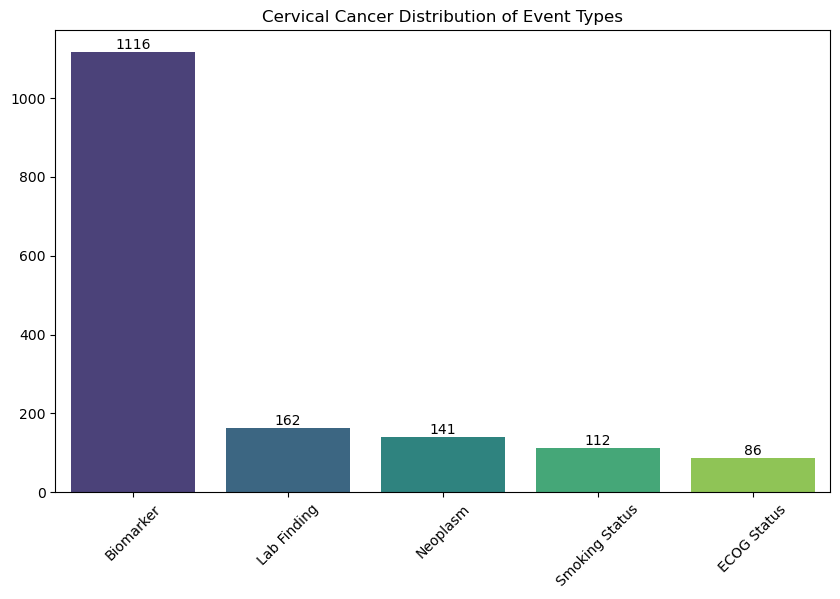

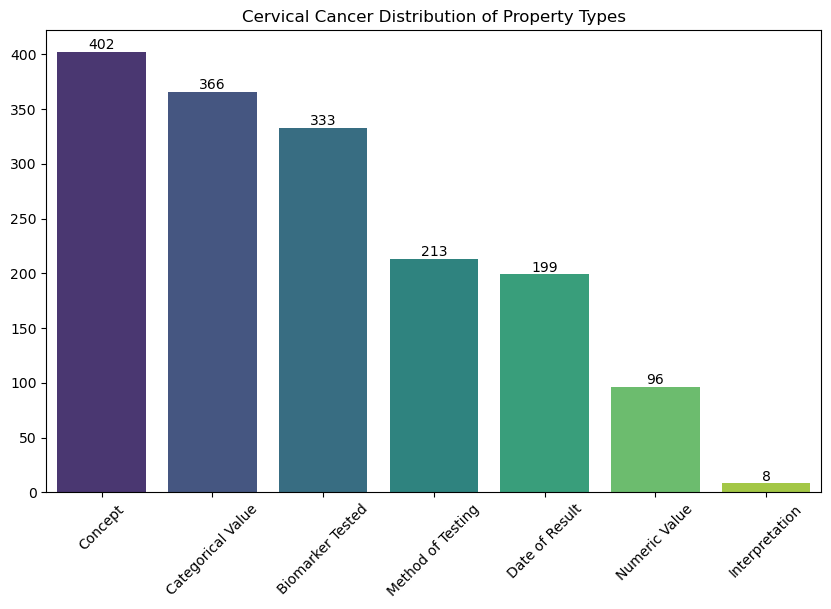

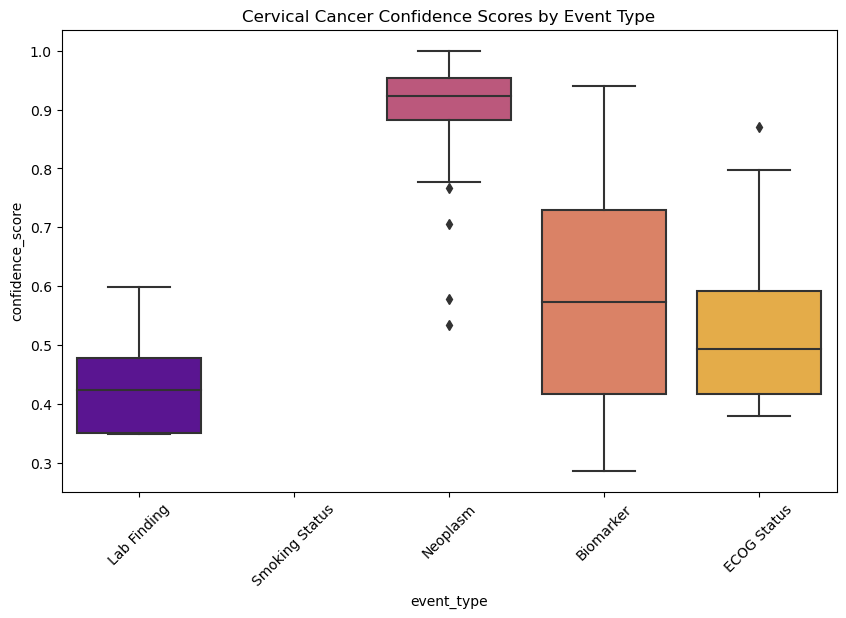

In [64]:
# Distribution of event types
event_type_counts = cervical_mendel_df['event_type'].value_counts()
create_colorful_bar_plot(cervical_mendel_df, event_type_counts.index, event_type_counts.values, 'Cervical Cancer Distribution of Event Types')

# Distribution of property types
property_type_counts = breast_mendel_df['property_type'].value_counts()
create_colorful_bar_plot(breast_mendel_df, property_type_counts.index, property_type_counts.values, 'Cervical Cancer Distribution of Property Types')

# Box plot of confidence scores by event type
create_colorful_box_plot(breast_mendel_df, 'event_type', 'confidence_score', 'Cervical Cancer Confidence Scores by Event Type')

In [65]:
print(len(cervical_mendel_df['all_concept_names'].unique()))
cervical_concept_counts = cervical_mendel_df['all_concept_names'].value_counts()
cervical_concept_counts[:20]

84


Positive                       152
Malignant Cervical Neoplasm    123
Immunohistochemistry           100
Next Generation Sequencing      75
Never Smoker                    73
Negative                        70
Gene Mutation                   52
Gene Mutation Negative          51
PDL1                            50
CDKN2A                          49
ECOG 1                          39
HPV Test                        34
TP53                            30
ER                              29
ECOG 0                          28
Former Smoker                   26
PR                              18
ERBB2                           18
BRCA2                           15
Sequencing                      15
Name: all_concept_names, dtype: int64

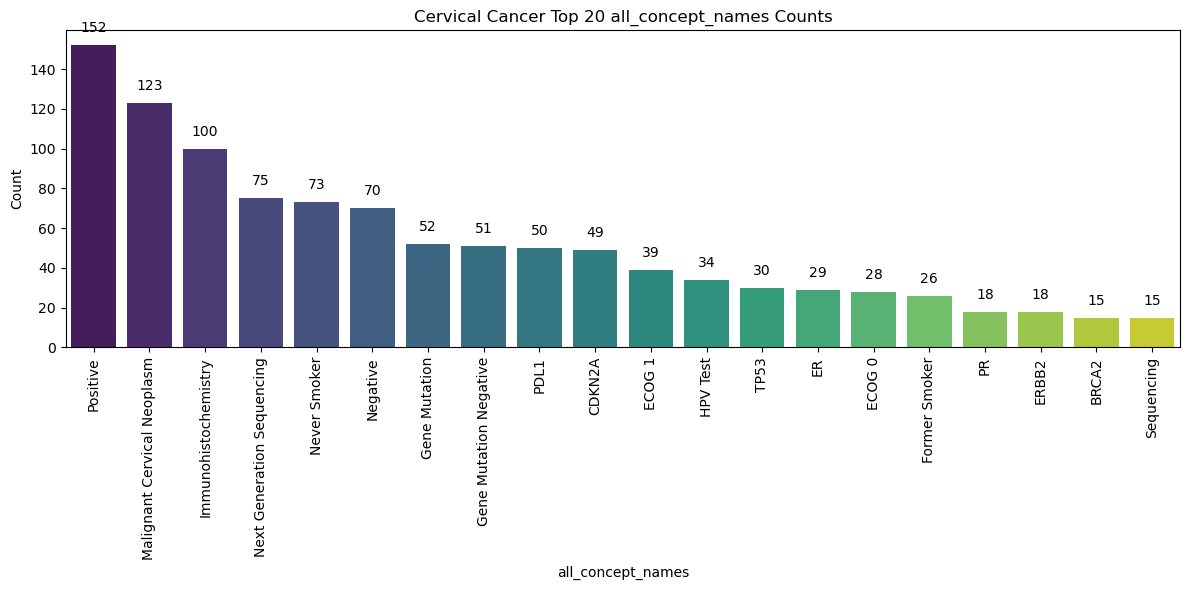

In [67]:
plot_top_concept_counts(cervical_mendel_df, 'all_concept_names', top_n=20)

### Results Extraction Comparison

In [28]:
# get dataframe with the same patients to compare extracted results 
import re

def merge_common_df(our_df, filtered_df):
    # Extract patient IDs from file names in our_df
    our_df['patient_id'] = our_df['file_name'].apply(lambda x: re.search(r'[A-Za-z0-9]+', x).group())

    # Filter unique patient IDs from our_df
    unique_patient_ids = our_df['patient_id'].unique()
    unique_our_df = our_df[our_df['patient_id'].isin(unique_patient_ids)]

    # Merge with filtered_df based on customer_patient_id
    merged_df = pd.merge(filtered_df, unique_our_df, left_on='customer_patient_id', right_on='patient_id')
    
    # Drop duplicates based on customer_patient_id
    merged_df = merged_df.drop_duplicates(subset='customer_patient_id', keep = 'first')

    return merged_df

In [30]:
def plot_merged_counts(data, column_name, title):
    plt.figure(figsize=(10, 6))
    unique_values = data[column_name].unique()
    num_unique_values = len(unique_values)
    color_map = plt.cm.get_cmap('tab20', num_unique_values)  # Get a colormap with enough colors
    
    ax = data[column_name].value_counts().plot(kind='bar', color=[color_map(i) for i in range(num_unique_values)])
    
    for p in ax.patches:
        ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='center', xytext=(0, 10), textcoords='offset points', color='black')
    
    plt.title(title)
    plt.xlabel(column_name)
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

In [36]:
merged_cervical_df = merge_common_df(cervical_our_df, cervical_mendel_df)
print("Number of comparing unique medical records: ",merged_cervical_df.shape[0] )

Number of comparing unique medical records:  136


#### HPV mentions

In [32]:
cervical_mendel_df.columns

Index(['customer_patient_id', 'event_type', 'confidence_score',
       'property_type', 'property_value_type', 'mention', 'all_concept_names',
       'document_id', 'start_char', 'end_char'],
      dtype='object')

In [33]:
cervical_mendel_hpv = cervical_mendel_df[cervical_mendel_df['all_concept_names']== 'HPV Test']
cervical_mendel_hpv.head()

,customer_patient_id,event_type,confidence_score,property_type,property_value_type,mention,all_concept_names,document_id,start_char,end_char
1,A0135348,Lab Finding,0.482272,Concept,Concept,HPV,HPV Test,doc-01h5jn0efe93yjy6p2ja9409jw,14147.0,14150.0
23,A81798,Lab Finding,0.477287,Concept,Concept,HPV,HPV Test,doc-01h5nw9s21bhvhvf8mqdrhtpx5,1056.0,1059.0
285,A0356445,Lab Finding,NaN,Concept,Concept,HPV,HPV Test,doc-01h5jn9jw6gcvrg0fb4k1csqjx,1203.0,1206.0
382,A0172738,Lab Finding,NaN,Concept,Concept,human papilloma virus (HPV)\n,HPV Test,doc-01h5jn9k0vscqmt1mp07ejxgkt,12384.0,12412.0
398,A0226942,Lab Finding,NaN,Concept,Concept,HPV,HPV Test,doc-01h5jm4xw70xezqy9fv68dp72p,15711.0,15714.0


In [34]:
merged_hpv_df = merge_common_df(cervical_our_df, cervical_mendel_hpv)

In [35]:
merged_hpv_df.shape

(26, 17)

In [37]:
merged_hpv_df.head()

,customer_patient_id,event_type,confidence_score,property_type,property_value_type,mention,all_concept_names,document_id,start_char,end_char,file_name,hpv_mentions,hpva_mentions,hpv_subtypes,nhpva_mentions,ebv_mentions,patient_id
0,A0135348,Lab Finding,0.482272,Concept,Concept,HPV,HPV Test,doc-01h5jn0efe93yjy6p2ja9409jw,14147.0,14150.0,A0135348.txt,"[{'start': 4228, 'end': 4231, 'text': 'hpv', '...",[],[],[],[],A0135348
1,A81798,Lab Finding,0.477287,Concept,Concept,HPV,HPV Test,doc-01h5nw9s21bhvhvf8mqdrhtpx5,1056.0,1059.0,A81798.txt,"[{'start': 903, 'end': 906, 'text': 'hpv', 'la...",[],[],[],[],A81798
2,A0356445,Lab Finding,NaN,Concept,Concept,HPV,HPV Test,doc-01h5jn9jw6gcvrg0fb4k1csqjx,1203.0,1206.0,A0356445_MedRec1.txt,"[{'start': 1162, 'end': 1165, 'text': 'hpv', '...",[],[],[],[],A0356445
3,A0172738,Lab Finding,NaN,Concept,Concept,human papilloma virus (HPV)\n,HPV Test,doc-01h5jn9k0vscqmt1mp07ejxgkt,12384.0,12412.0,A0172738.txt,"[{'start': 15973, 'end': 15976, 'text': 'hpv',...","[{'start': 11677, 'end': 11691, 'text': 'villo...",[],[],[],A0172738
4,A0226942,Lab Finding,NaN,Concept,Concept,HPV,HPV Test,doc-01h5jm4xw70xezqy9fv68dp72p,15711.0,15714.0,A0226942.txt,"[{'start': 14984, 'end': 14987, 'text': 'hpv',...",[],[],[],[],A0226942


In [40]:
# mendel 
print(merged_hpv_df['mention'].nunique())
print(merged_hpv_df['mention'].unique())

7
['HPV' 'human papilloma virus (HPV)\n' ' HPV' 'HPV ' 'positive HPV'
 'HPV   ' 'HPRNAE6/E7']


In [41]:
# ours 
merged_hpv_df['hpv_mentions'].iloc[1]

[{'start': 903,
  'end': 906,
  'text': 'hpv',
  'label': 'HPV',
  'keyword': '0/17 1:42:pm pulse 110 bpm o02 saturation 99% temperature 96.90 °f height 66 in weight 124.40 ib bmi | 20.08 blood pressure 123/75 mmhg subjective problem list: 1. metastatic cervical cancer a. 11/2016 initially felt pain in her pelvic area while in dubai b. 05/2017 abnormal pap smear with positive hpv result ¢, 05/23/2017 underwent colposcopy. biopsy performed in dubai showed a malignant tumor consistent with invasive carcinoma with glandular and possible squamous features. d. 06/08/2017 pet/ct scan showed a mass in the cervix with mmsuv 12.3. there were multiple bilateral fdg avid pelvic lymph',
  'gene_mentions': [],
  'test_result': 'positive'},
 {'start': 10355,
  'end': 10358,
  'text': 'hpv',
  'label': 'HPV',
  'keyword': '4/17 9:48:am pulse 101 bpm o02 saturation 98% temperature 97.50 °f height 66 in weight 127.40 ib bmi : 20.56 blood pressure 116/75 mmhg subjective problem list: 1. metastatic cervi

In [45]:
merged_hpv_df['hpv_subtypes'].iloc[10]

[]

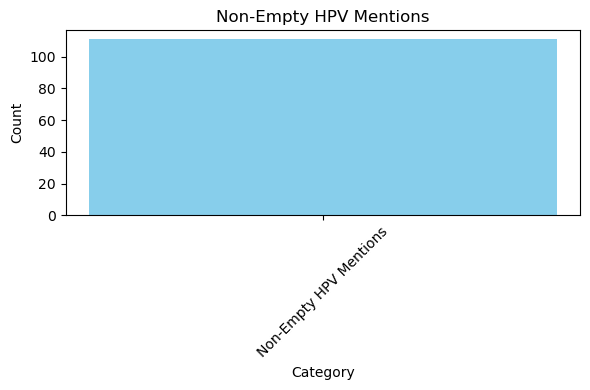

In [42]:
import matplotlib.pyplot as plt

# Count non-empty HPV mentions
non_empty_hpv_mentions = merged_hpv_df['hpv_mentions'].apply(lambda x: len(x)).sum()

# Calculate percentage of non-empty HPV mentions based on all documents
total_documents = len(merged_hpv_df)
non_empty_hpv_mentions_percentage = (non_empty_hpv_mentions / total_documents) * 100

# Visualize Non-Empty HPV Mentions
plt.figure(figsize=(6, 4))
plt.bar(['Non-Empty HPV Mentions'], [non_empty_hpv_mentions], color='skyblue')
plt.title('Non-Empty HPV Mentions')
plt.ylabel('Count')
plt.xlabel('Category')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

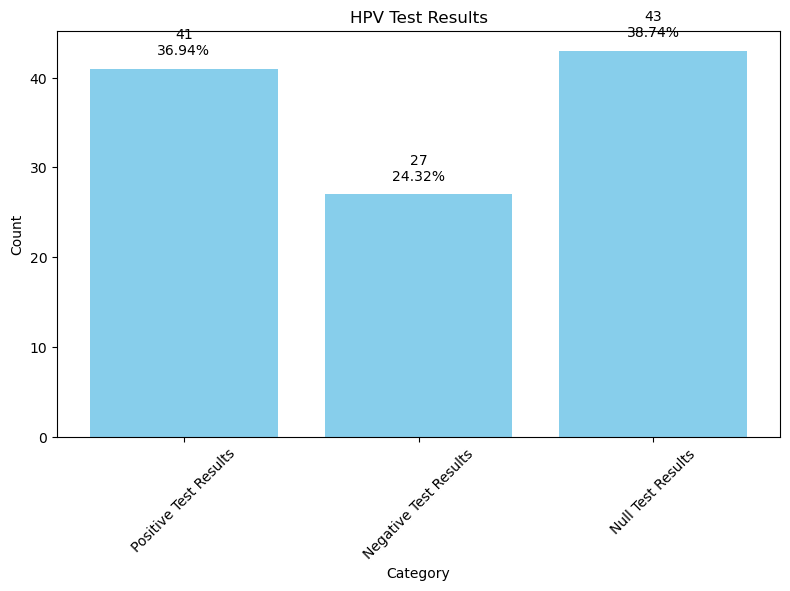

In [43]:
# Count test_result values
test_results = [mention['test_result'] for mentions in merged_hpv_df['hpv_mentions'] for mention in mentions]
total_test_results = len(test_results)
positive_count = test_results.count('positive')
negative_count = test_results.count('negative')
other_count = total_test_results - (positive_count + negative_count)

# Calculate percentages
positive_percentage = (positive_count / total_test_results) * 100
negative_percentage = (negative_count / total_test_results) * 100
other_percentage = (other_count / total_test_results) * 100

# Visualize Test Results
labels = ['Positive Test Results', 'Negative Test Results', 'Null Test Results']
counts = [positive_count, negative_count, other_count]
percentages = [positive_percentage, negative_percentage, other_percentage]

plt.figure(figsize=(8, 6))
plt.bar(labels, counts, color='skyblue')
plt.title('HPV Test Results')
plt.ylabel('Count')
plt.xlabel('Category')
plt.xticks(rotation=45)
plt.tight_layout()

# Annotate counts and percentages on the bars
for i, (count, percentage) in enumerate(zip(counts, percentages)):
    plt.annotate(f'{count}\n{percentage:.2f}%', (i, count), textcoords="offset points", xytext=(0,10), ha='center')

plt.show()

In [47]:
# hpv subtypes 
import matplotlib.pyplot as plt
from collections import Counter

# Extract HPV subtypes from the DataFrame
hpv_subtypes = [subtype['text'] for subtypes_list in merged_hpv_df['hpv_subtypes'] for subtype in subtypes_list]

# Count the occurrences of each HPV subtype
hpv_subtype_counts = Counter(hpv_subtypes)

# Get the top 20 HPV subtypes and their counts
top_hpv_subtypes = hpv_subtype_counts.most_common(20)
top_hpv_subtype_names = [subtype[0] for subtype in top_hpv_subtypes]
top_hpv_subtype_counts = [subtype[1] for subtype in top_hpv_subtypes]

# # Visualize the top 20 HPV subtypes
# plt.figure(figsize=(12, 8))
# plt.barh(top_hpv_subtype_names, top_hpv_subtype_counts, color='skyblue')
# plt.title('Top 20 HPV Subtypes')
# plt.xlabel('Count')
# plt.ylabel('HPV Subtype')
# plt.tight_layout()
# plt.show()

In [48]:
print(len(hpv_subtypes))

0


Total number of unique gene mentions:  93


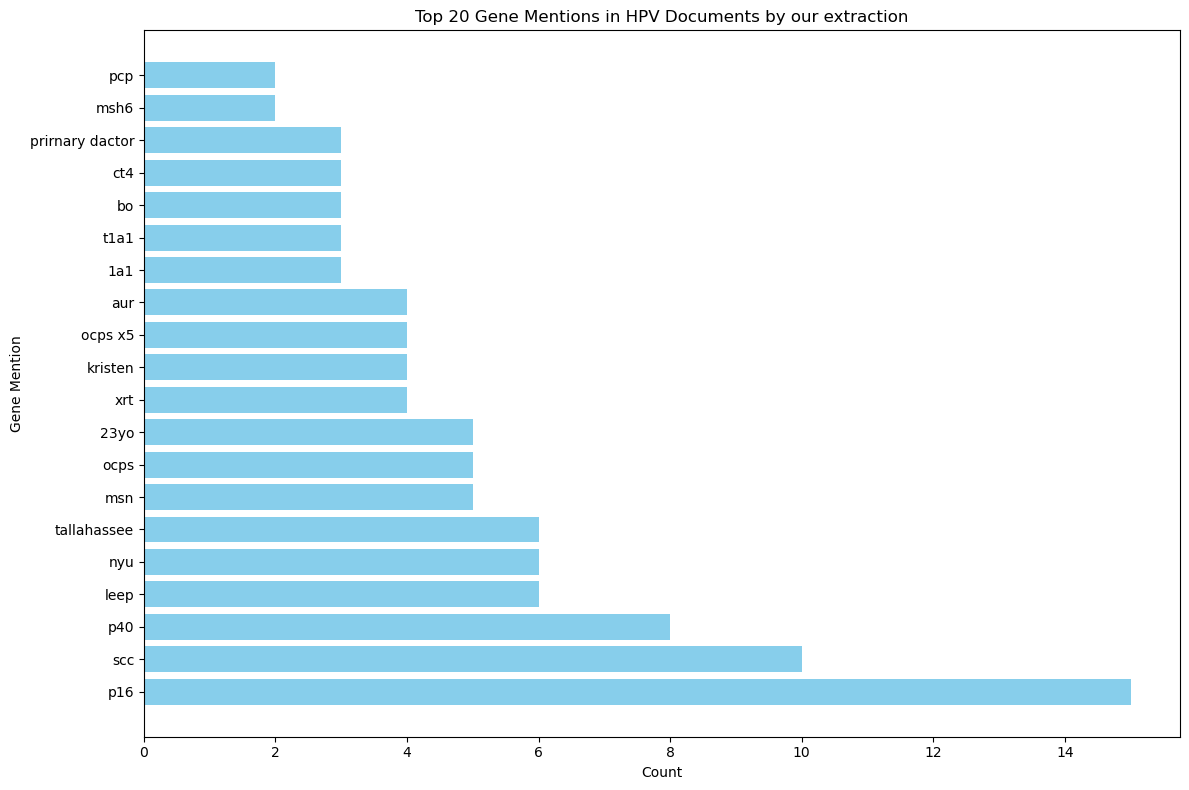

In [62]:
# hpv gene mentions
# Extract gene mentions from the DataFrame
gene_mentions = []
for mentions_list in merged_hpv_df['hpv_mentions']:
    for mentions_dict in mentions_list:
        gene_mentions.extend([mention['text'] for mention in mentions_dict.get('gene_mentions', [])])
        
# Count the occurrences of each gene mention
gene_mention_counts = Counter(gene_mentions)
print("Total number of unique gene mentions: ", len(gene_mention_counts.keys()))

# Get the top 20 gene mentions and their counts
top_gene_mentions = gene_mention_counts.most_common(20)
top_gene_mention_names = [mention[0] for mention in top_gene_mentions]
top_gene_mention_counts = [mention[1] for mention in top_gene_mentions]

# Visualize the top 20 gene mentions
plt.figure(figsize=(12, 8))
plt.barh(top_gene_mention_names, top_gene_mention_counts, color='skyblue')
plt.title('Top 20 Gene Mentions in HPV Documents by our extraction')
plt.xlabel('Count')
plt.ylabel('Gene Mention')
plt.tight_layout()
plt.show()

In [58]:
# visualize "Positive" concept names by Mendel 
cervical_mendel_positive = cervical_mendel_df[cervical_mendel_df['all_concept_names'] == 'Positive']
merged_positive_df = merge_common_df(cervical_our_df, cervical_mendel_positive)

In [59]:
merged_positive_df.shape

(72, 17)

In [60]:
merged_positive_df.head()

,customer_patient_id,event_type,confidence_score,property_type,property_value_type,mention,all_concept_names,document_id,start_char,end_char,file_name,hpv_mentions,hpva_mentions,hpv_subtypes,nhpva_mentions,ebv_mentions,patient_id
0,A0135348,Biomarker,0.840574,Categorical Value,Concept,+,Positive,doc-01h5jn0efe93yjy6p2ja9409jw,9007.0,9008.0,A0135348.txt,"[{'start': 4228, 'end': 4231, 'text': 'hpv', '...",[],[],[],[],A0135348
3,A81798,Lab Finding,0.477287,Categorical Value,Concept,positive,Positive,doc-01h5nw9s21bhvhvf8mqdrhtpx5,1047.0,1055.0,A81798.txt,"[{'start': 903, 'end': 906, 'text': 'hpv', 'la...",[],[],[],[],A81798
4,A0408848,Lab Finding,NaN,Categorical Value,Concept,positive,Positive,doc-01h5nw9s8mkc856xnzsgeqx7t0,4494.0,4502.0,A0408848_MedRec1.txt,"[{'start': 6617, 'end': 6620, 'text': 'hpv', '...",[],"[{'start': 9949, 'end': 9955, 'text': 'hpv-16'...",[],[],A0408848
5,A0569924,Biomarker,NaN,Categorical Value,Concept,Gene Expression,Positive,doc-01h5jn9ka03eqhgm8m27gd18jx,16598.0,16613.0,A0569924_MedRec1.txt,"[{'start': 28519, 'end': 28522, 'text': 'hpv',...",[],[],[],[],A0569924
17,A0438581,Biomarker,NaN,Categorical Value,Concept,positive,Positive,doc-01h5nw9s7rcm3zz7yggz7w3q0z,1964.0,1972.0,A0438581_MedRec1.txt,[],[],[],"[{'start': 2563, 'end': 2590, 'text': 'endomet...",[],A0438581
